In [6]:
import argparse
import scipy.io as sio
import time
import random
import sys
from PUDIPFlowWrapper import *

In [7]:
seed = 12345
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
sys.argv = [""]

parser = argparse.ArgumentParser(description='Process some MRI data.')
parser.add_argument('--datapath', type=str, default='./data/testdata.npz')
parser.add_argument('--iternum', type=int, default=300) # just for show
parser.add_argument('--lr', type=float, default=0.01)
parser.add_argument('--venc', type=int, default=50)
parser.add_argument('--inputdepth', type=int, default=128)
parser.add_argument('--featurenum', type=int, default=128)
parser.add_argument('--loss', type=str, default='l1')
parser.add_argument('--vsize', type=int, default=1)
parser.add_argument('--vstart', type=int, default=0)
parser.add_argument('--tsize', type=int, default=0)
parser.add_argument('--tstart', type=int, default=0)
parser.add_argument('--level', type=int, default=4)
parser.add_argument('--device', type=str, default='cuda:0')
parser.add_argument('--TemporalTV', type=float, default=1.0)

args = parser.parse_args()

In [8]:
data = np.load('./data/testdata.npz', allow_pickle=True)['arr_0'].item()
img = data['img']
Nv, Nt, FE, PE, SPE = img.shape
segmask = data['segmask']
segmask = np.repeat(segmask, Nt, 1)
args.tsize = Nt
orivenc = 150
venc = 50
show_SPE = 12
show_T = 4
flowgt = np.angle(img[1:] * np.conj(img[0:1])) / np.pi * orivenc
wrapped_flow = np.angle(np.exp(1j * (np.angle(img[1:]) - np.angle(img[0:1])) * orivenc / venc))
flow_dip = np.zeros((3, Nt, FE, PE, SPE))
mag = np.mean(np.abs(img), axis=0, keepdims=True)
vmag = np.sqrt(np.sum(np.abs(wrapped_flow) ** 2, axis=0, keepdims=True))
Nv, Nt, FE, PE, SPE = img.shape
weightmask = np.std(mag * vmag, axis=1, keepdims=True) * mag * vmag  # PCMRA * std
# weightmask = mag * vmag                                              # PCMRA
# weightmask = np.mean(vmag * mag, axis=1, keepdims=True)              # \bar PCMRA
# weightmask = np.ones_like(mag * vmag)                                # None

for args.vstart in [2,1,0]:   
    ans = PUDIP(wrapped_flow[args.vstart:args.vstart+1].copy(), weightmask, args, segmask=segmask, gt=np.expand_dims(flowgt, axis=0)[:, args.vstart], 
    show_SPE=show_SPE, show_T=show_T).detach().cpu().numpy()
    flow_dip[args.vstart] = ans

Epoch [300/300]: 100%|██████████| 300/300 [00:26<00:00, 11.24it/s]


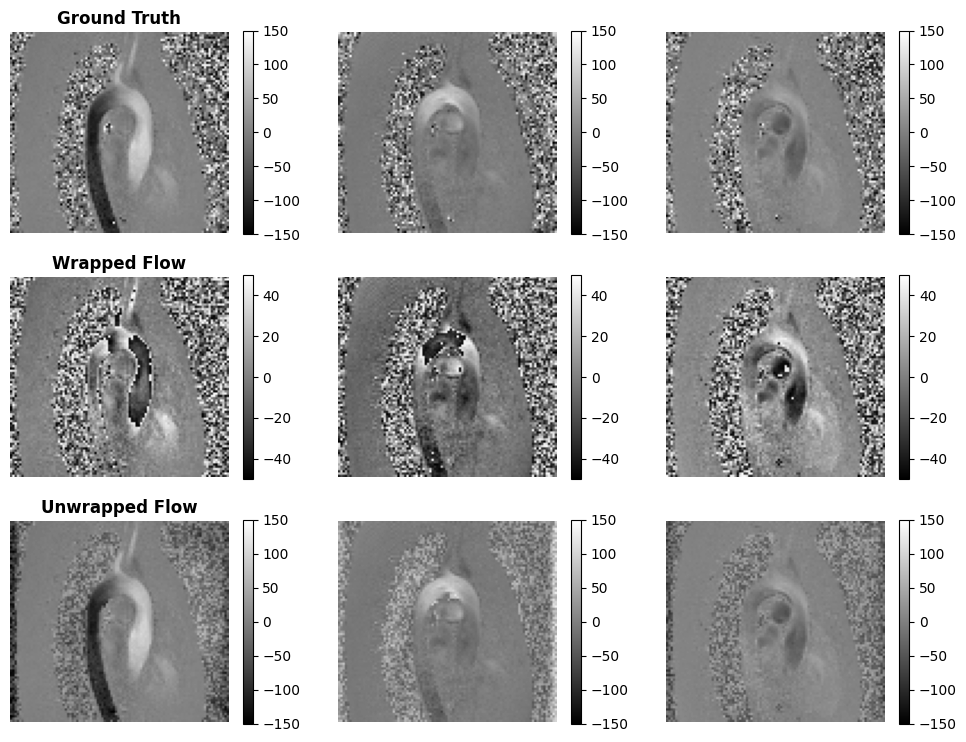

In [9]:
plt.figure(figsize=(12, 9))
for i in range(3):
    plt.subplot(3,3,i+1)
    plt.imshow(flowgt[i, show_T, :, :, show_SPE],cmap='gray')
    if i == 0:
        plt.title("Ground Truth", fontweight='bold')
    plt.clim(-orivenc, orivenc)
    plt.colorbar()
    plt.axis('off')
    plt.subplot(3,3,i+4)
    plt.imshow(wrapped_flow[i, show_T, :, :, show_SPE] / np.pi * venc,cmap='gray')
    if i == 0:
        plt.title("Wrapped Flow", fontweight='bold')
    plt.clim(-venc, venc)
    plt.colorbar()
    plt.axis('off')
    plt.subplot(3,3,i+7)
    plt.imshow(flow_dip[i, show_T, :, :, show_SPE] ,cmap='gray')
    if i == 0:
        plt.title("Unwrapped Flow", fontweight='bold')
    plt.clim(-orivenc, orivenc)
    plt.colorbar()
    plt.axis('off')
plt.show()